In [ ]:
!unzip xray-detection.v16i.coco.zip -d data/

Archive:  xray-detection.v16i.coco.zip
  inflating: data/README.dataset.txt  
  inflating: data/README.roboflow.txt  
   creating: data/test/
 extracting: data/test/468_png.rf.27eda7e5bc9f38dbe07f0ec1ef94b741.jpg  
 extracting: data/test/474_png.rf.9c839943604a4413b1e31b9271aa86fc.jpg  
 extracting: data/test/476_png.rf.01a81a9a3015c22e9ee14e5c8b6c9b85.jpg  
 extracting: data/test/493_png.rf.c05c9560d829652b8a8b26570fc4c7f1.jpg  
 extracting: data/test/498_png.rf.721fb95a7fc72b0abd479f097a10081c.jpg  
 extracting: data/test/49_png.rf.22c7e86614e0ab6294017f1fafe81e24.jpg  
 extracting: data/test/504_png.rf.4cd6d2317285c83ca848b89f8d55f79e.jpg  
 extracting: data/test/50_png.rf.5f783190f9a1afce04051aec1b2c1a17.jpg  
 extracting: data/test/510_png.rf.fafd84d4a8df43199deeb78aefd0b016.jpg  
 extracting: data/test/516_png.rf.68edf90c33455facab6b1907e4dbe7bb.jpg  
 extracting: data/test/517_png.rf.b606ec1c5bae8f0e0fe9c5e7d19901b3.jpg  
 extracting: data/test/519_png.rf.0ba0f2376e004ebd6349a50

In [ ]:
!pip install -qU pycocotools transformers albumentations torchmetrics supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.9/269.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 46.3 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
import requests

id2label = {
    0: "periodontitis-impaction-caries",
    1: "caries",
    2: "impaction",
    3: "periodontitis",
}

label2id = {v: k for k, v in id2label.items()}

In [ ]:
!unrar x detr_xray.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from detr_xray.rar

Creating    detr_xray                                                 OK
Extracting  detr_xray/config.json                                          0%  OK 
Extracting  detr_xray/model.safetensors                                    2%  5%  8% 10% 13% 16% 18% 21% 24% 27% 29% 32% 35% 37% 40% 43% 45% 48% 51% 54% 56% 59% 62% 64% 67% 70% 73% 75% 78% 81% 83% 86% 89% 91% 94% 97% 99%  OK 
Extracting  detr_xray/preprocessor_config.json                            99%  OK 
Extracting  detr_xray/training_args.bin                                   99%  OK 
All OK


In [ ]:
from transformers import DetrForObjectDetection, DetrImageProcessor
import torch
'''
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
'''

model = DetrForObjectDetection.from_pretrained(
    "/content/detr_xray",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torch
import os
from PIL import Image
import numpy as np
import albumentations as A
import cv2
from torch.utils.data import random_split

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, image_dir, processor):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.processor = processor
        self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')

        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=[image_id]))

        targets = {
            'image_id': torch.tensor([image_id]),
            'annotations': annotations,
        }

        return self.processor(images=image, annotations=targets, return_tensors="pt")


In [ ]:
train_dataset = CustomDataset(
    annotation_file="/content/data/train/_annotations.coco.json",
    image_dir="/content/data/train",
    processor=processor,
)
test_dataset = CustomDataset(
    annotation_file="/content/data/test/_annotations.coco.json",
    image_dir="/content/data/test",
    processor=processor,
)
valid_dataset = CustomDataset(
    annotation_file="/content/data/valid/_annotations.coco.json",
    image_dir="/content/data/valid",
    processor=processor,
)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

1089
48
66


In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"].squeeze(0).cpu() for item in batch]
    pixel_values = np.array(pixel_values)
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"][0] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"].to(device)
    batch["pixel_mask"] = encoding["pixel_mask"].to(device)
    batch["labels"] = labels

    return batch

In [ ]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    boxes = center_to_corners_format(boxes)

    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [ ]:
import torch
from typing import Mapping, Optional
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers.modeling_outputs import ModelOutput
from transformers.trainer_utils import EvalPrediction
from transformers import AutoImageProcessor
from dataclasses import dataclass
import torch
from functools import partial

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(
    evaluation_results: EvalPrediction,
    image_processor: AutoImageProcessor,
    threshold: float = 0.0,
    id2label: Optional[Mapping[int, str]] = None,
) -> Mapping[str, float]:


    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor([x["orig_size"] for x in batch])
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics

eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=processor, id2label=id2label, threshold=0.0
)

In [ ]:
from transformers import get_cosine_schedule_with_warmup

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=30,
    lr_scheduler_type="cosine",
    fp16=False,
    save_strategy="epoch",
    logging_strategy="epoch",
    max_grad_norm=0.01,
    learning_rate=1e-5,
    weight_decay=1e-5,
    save_total_limit=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    report_to="none",
    dataloader_pin_memory=False,
    eval_do_concat_batches=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=eval_compute_metrics_fn,
)

<ipython-input-13-5b98531d23ad>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

TrainOutput(global_step=32670, training_loss=0.6477502052813887, metrics={'train_runtime': 7390.0481, 'train_samples_per_second': 4.421, 'train_steps_per_second': 4.421, 'total_flos': 1.56101454723456e+19, 'train_loss': 0.6477502052813887, 'epoch': 30.0})

In [ ]:
image_url = "/content/468_png.rf.27eda7e5bc9f38dbe07f0ec1ef94b741.jpg"
image = Image.open(image_url).convert("RGB")

In [ ]:
inputs = processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

In [ ]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"Sınıf: {model.config.id2label[label.item()]}, Güven: {score.item():.3f}, Sınırlayıcı Kutu: {box.tolist()}")

Sınıf: caries, Güven: 0.876, Sınırlayıcı Kutu: [262.1298522949219, 269.7710876464844, 289.0539855957031, 368.2925720214844]
Sınıf: impaction, Güven: 0.991, Sınırlayıcı Kutu: [471.19921875, 339.2840270996094, 516.1806640625, 431.4140625]
Sınıf: impaction, Güven: 0.993, Sınırlayıcı Kutu: [434.5643615722656, 189.2127227783203, 483.05694580078125, 271.8666076660156]
Sınıf: impaction, Güven: 0.983, Sınırlayıcı Kutu: [158.69676208496094, 159.4537353515625, 201.32745361328125, 247.07313537597656]
Sınıf: impaction, Güven: 0.993, Sınırlayıcı Kutu: [123.53472900390625, 324.1651916503906, 167.142333984375, 421.52191162109375]


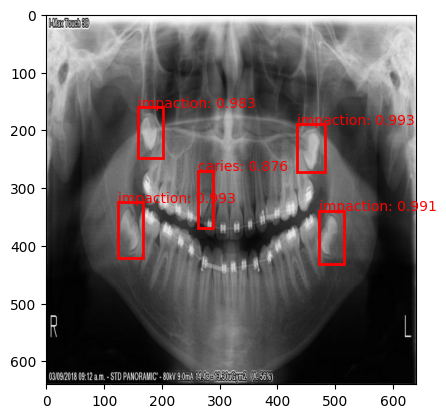

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.tolist()

    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor="r", facecolor="none")

    ax.add_patch(rect)

    ax.text(xmin, ymin, f"{model.config.id2label[label.item()]}: {score.item():.3f}", color="r")

plt.show()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


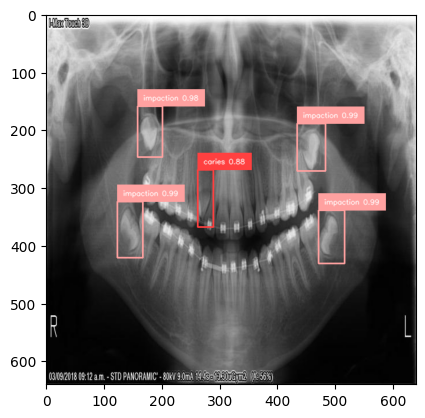

In [ ]:
import supervision as sv

detections = sv.Detections.from_transformers(results).with_nms(threshold=0.5)
scores = [score.item() for score in results["scores"]]
labels = [
    f"{model.config.id2label[class_id]} {score:.2f}"
    for class_id, score
    in zip(detections.class_id, scores)
]

box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator(
    text_scale=0.4,
    text_thickness=1,
)

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
plt.imshow(annotated_frame)
plt.show()

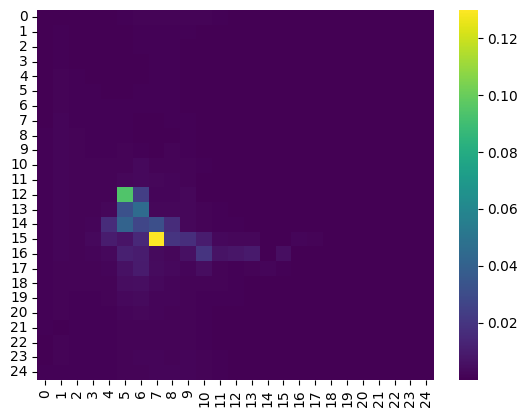

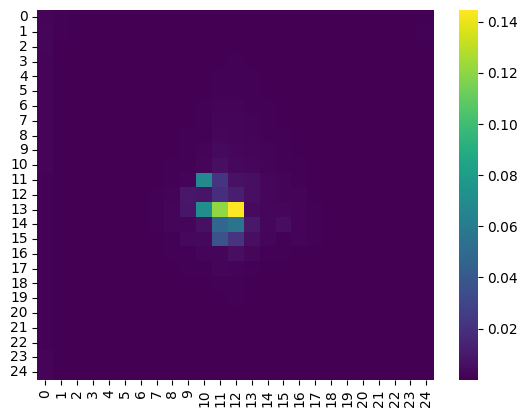

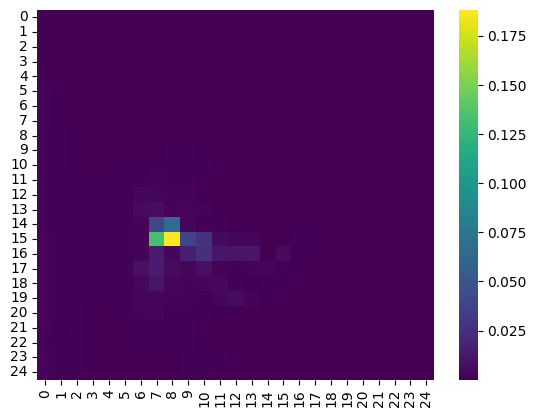

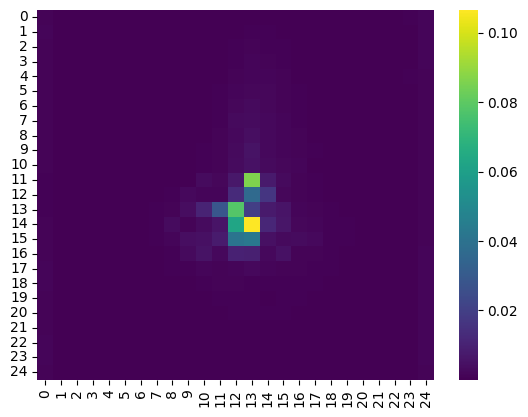

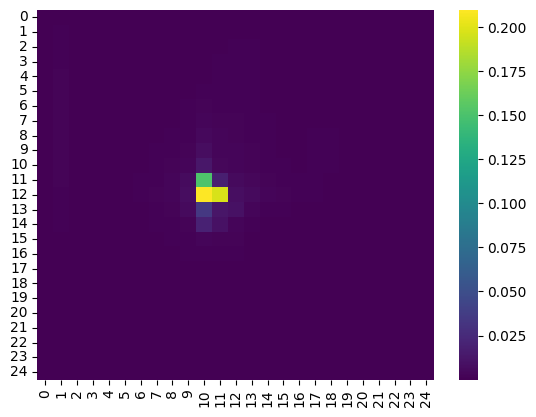

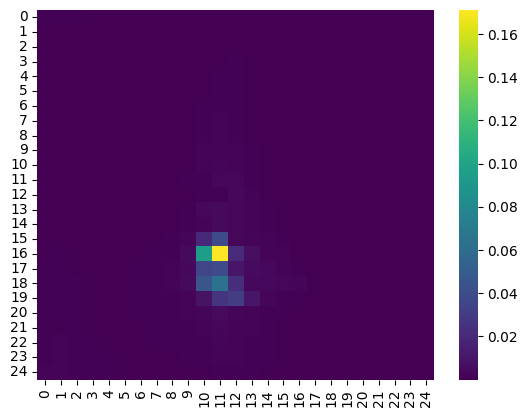

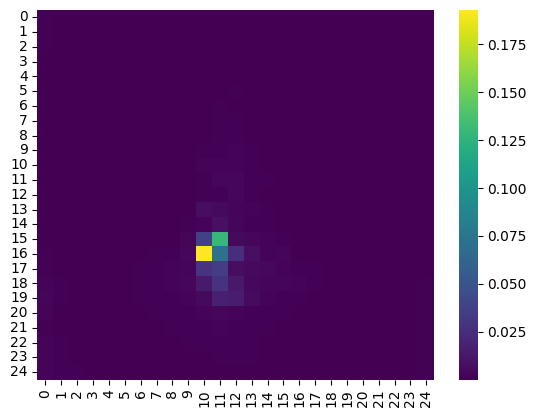

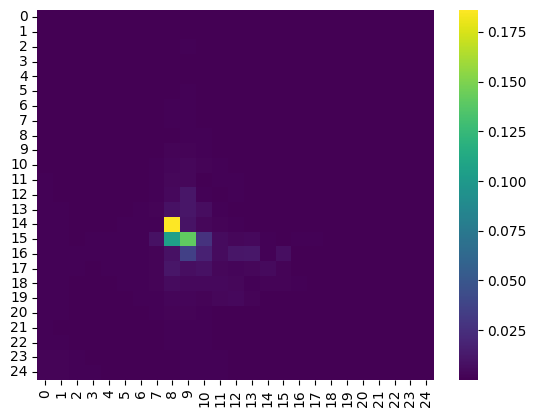

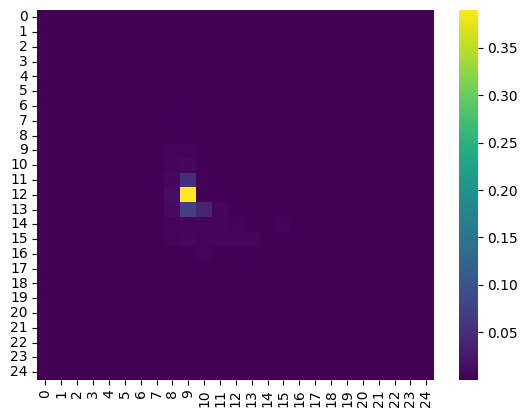

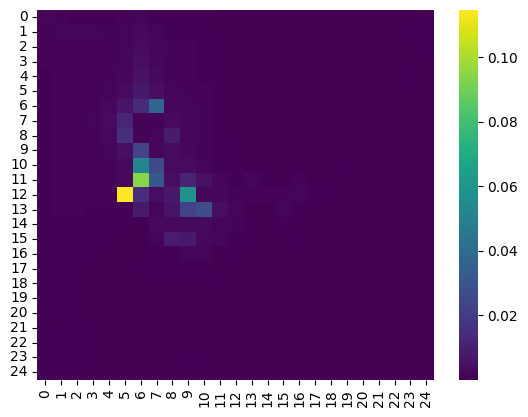

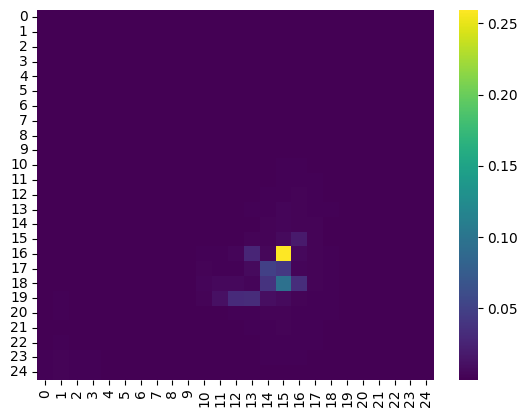

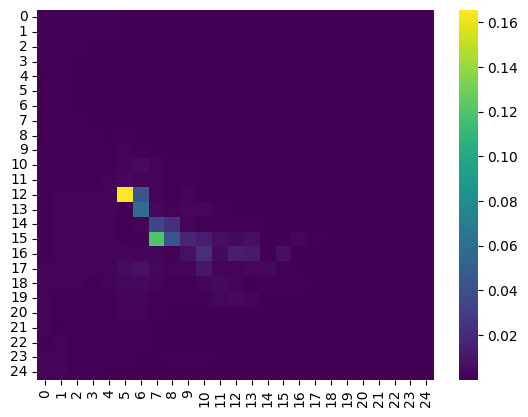

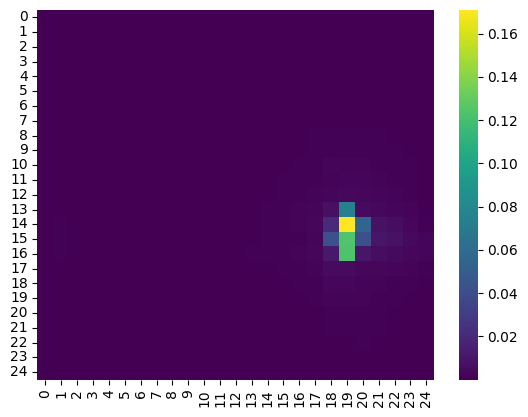

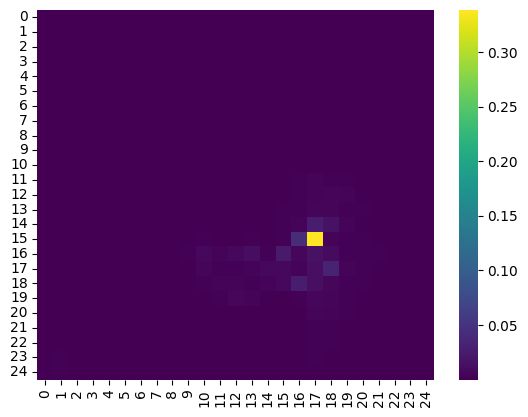

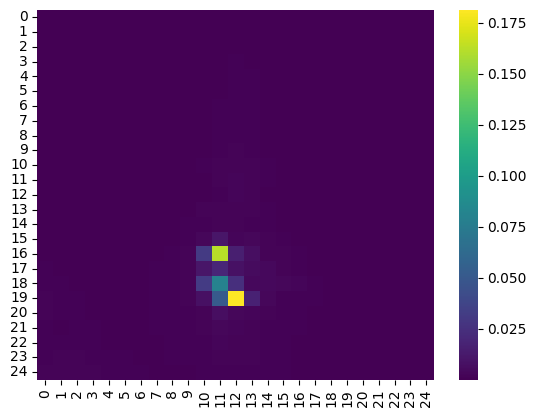

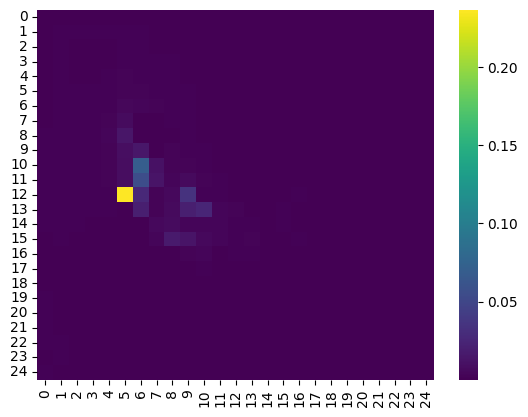

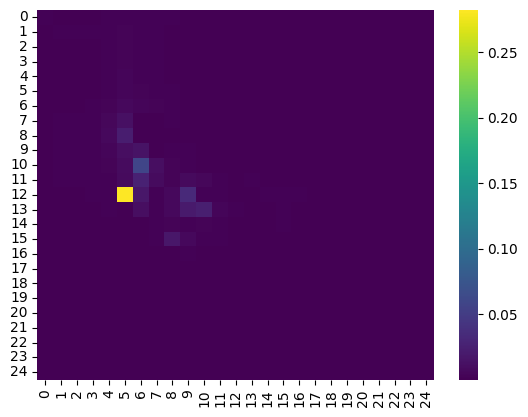

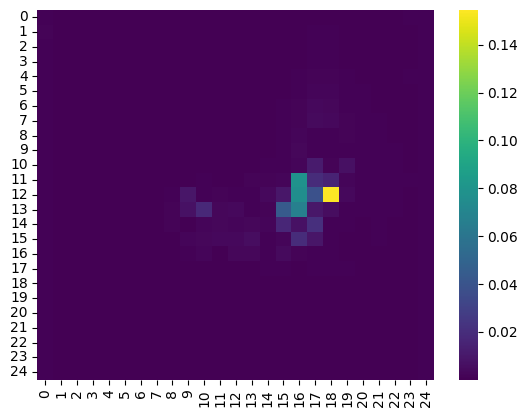

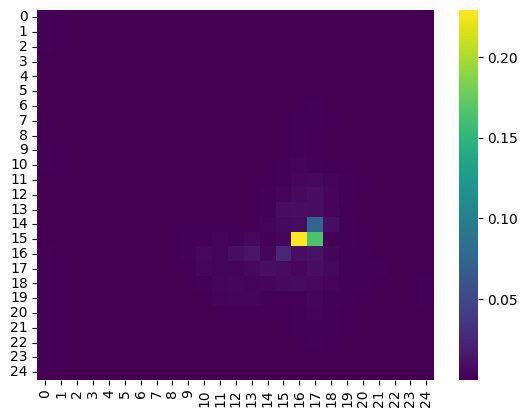

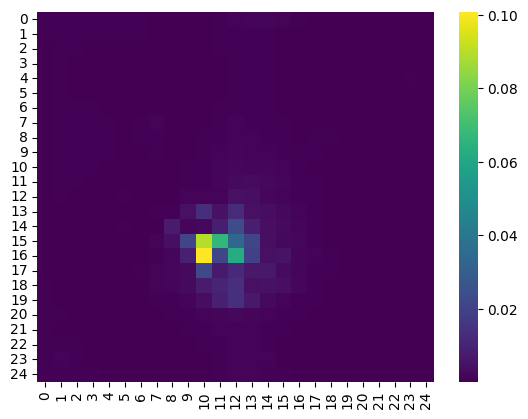

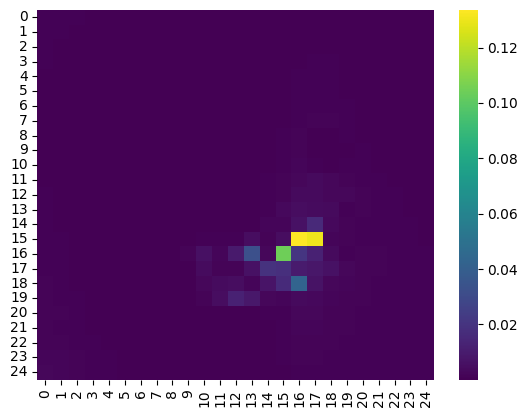

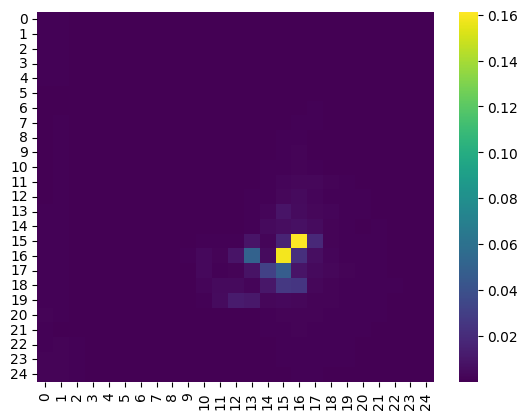

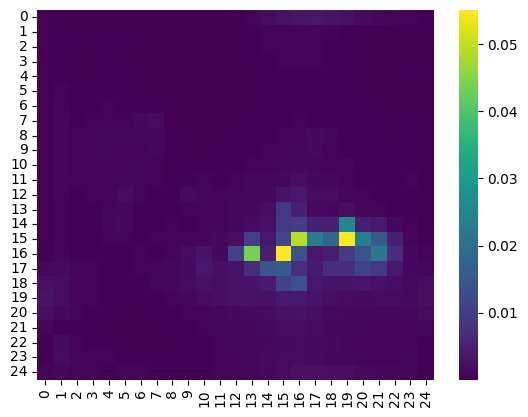

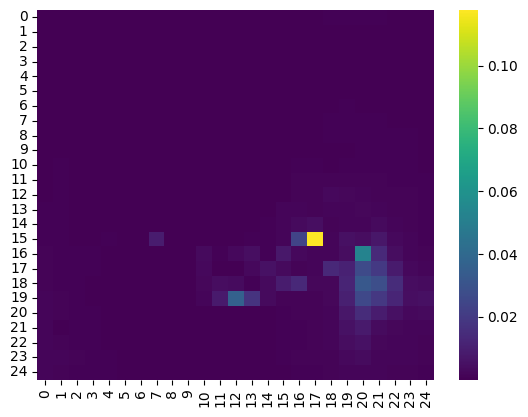

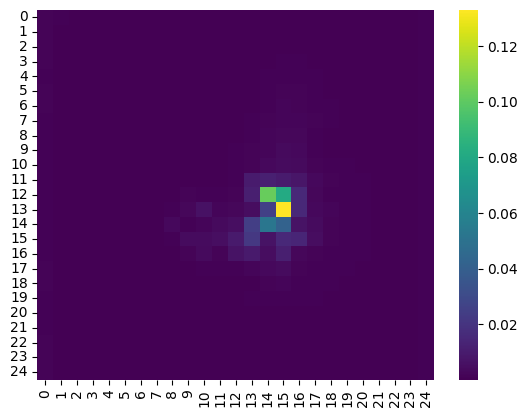

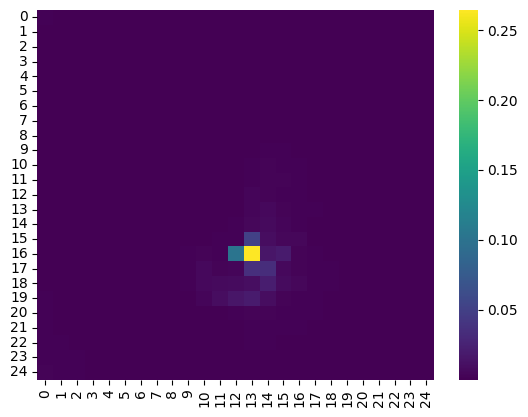

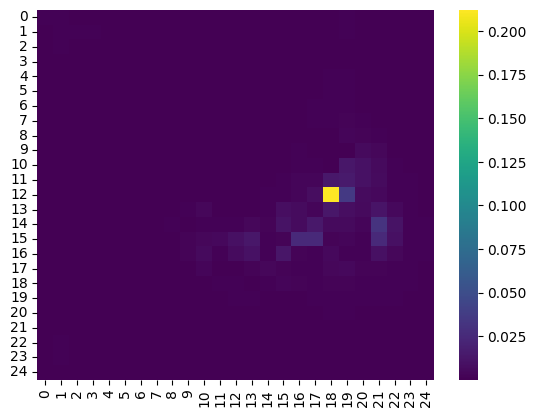

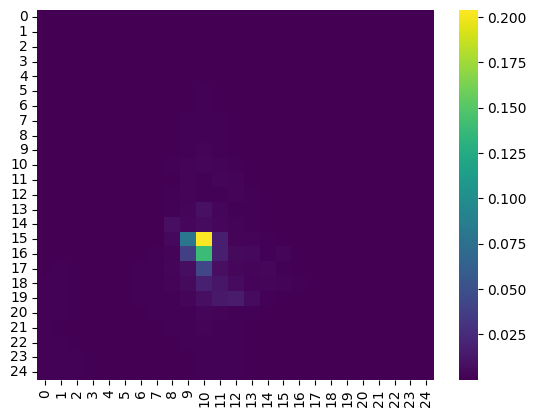

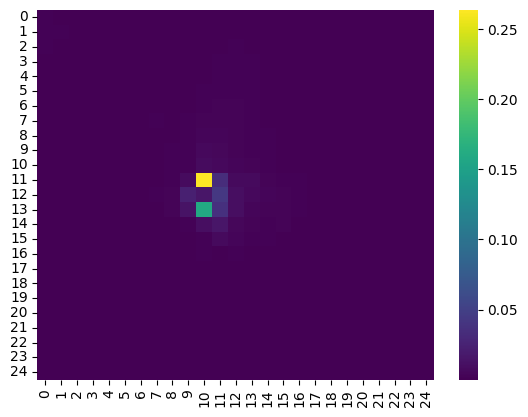

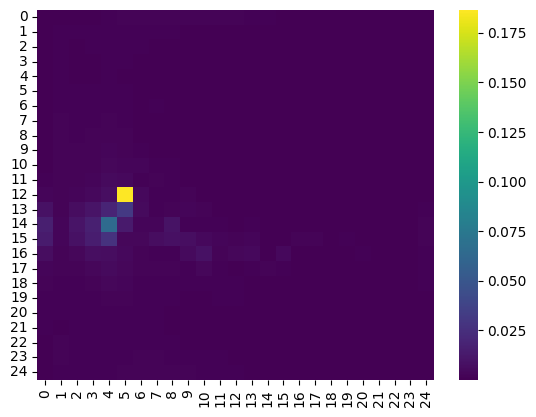

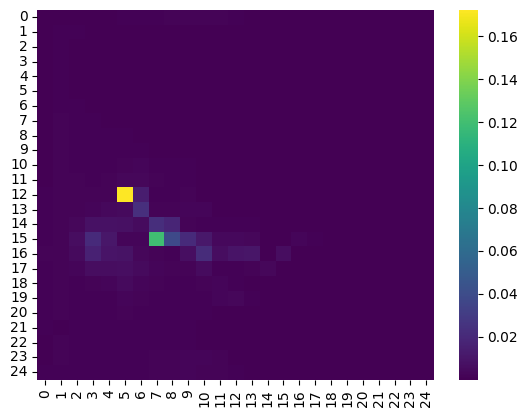

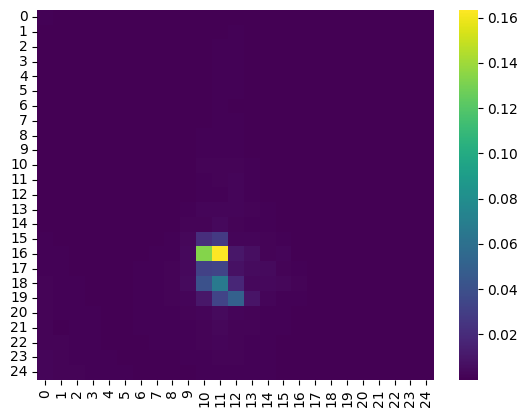

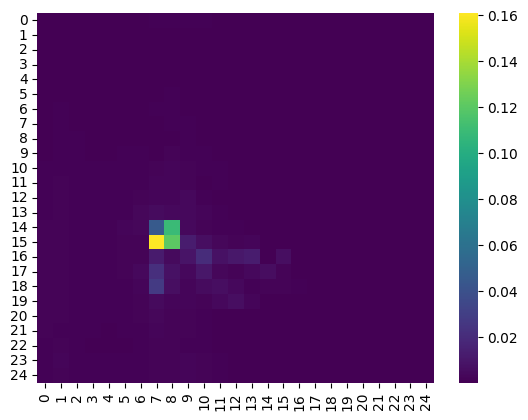

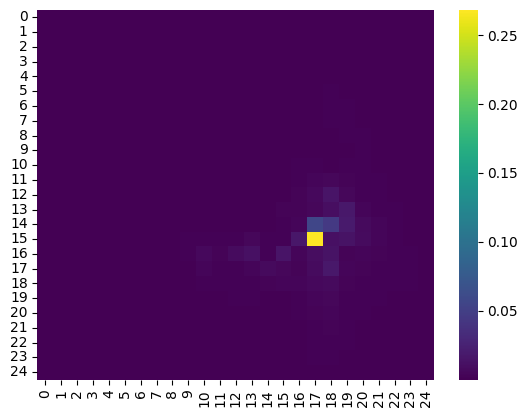

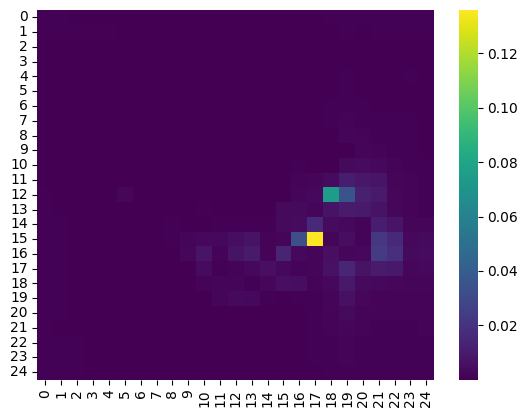

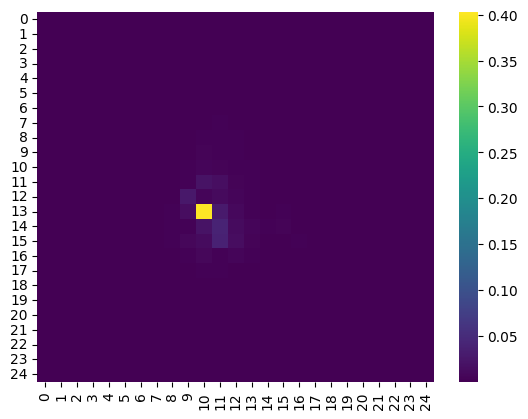

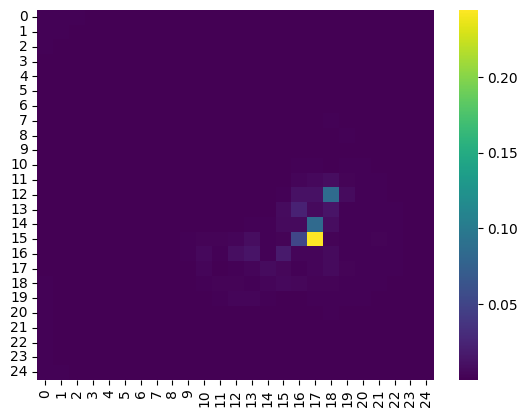

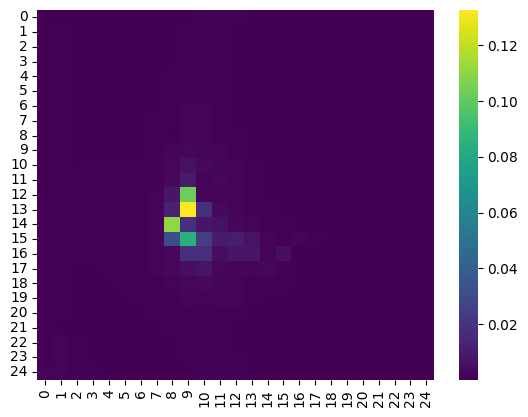

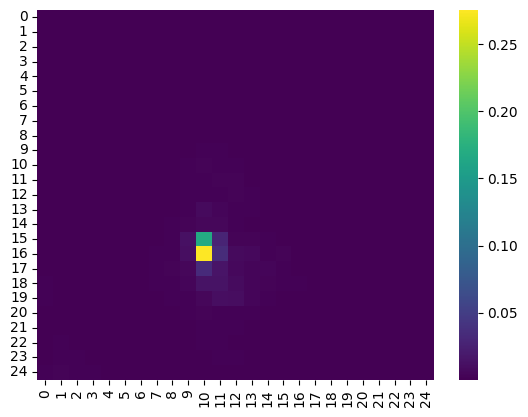

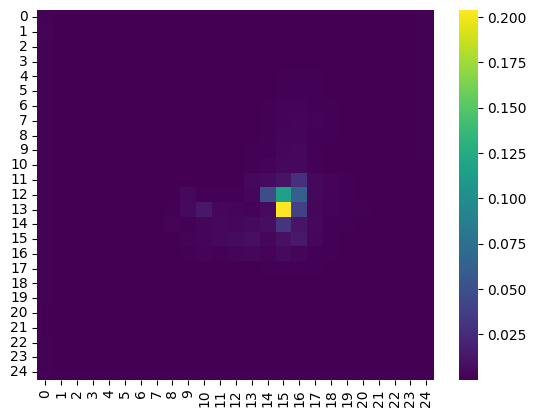

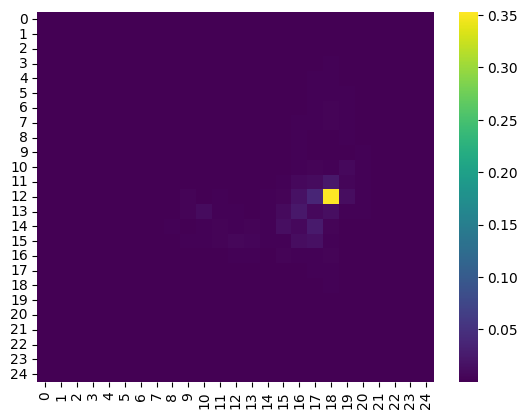

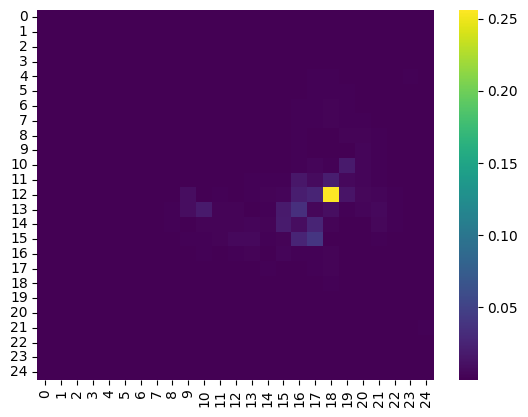

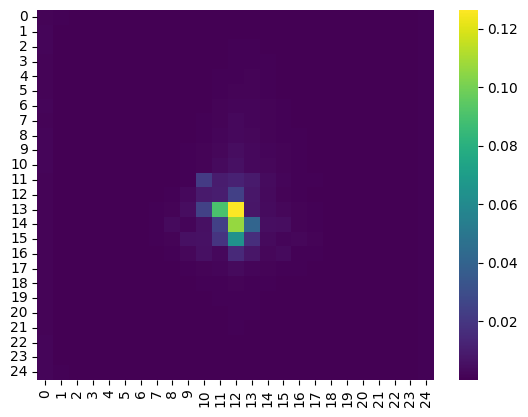

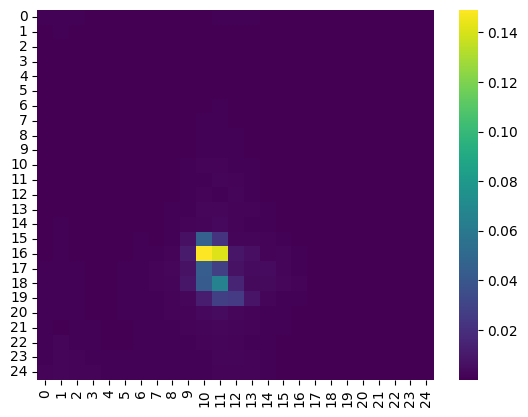

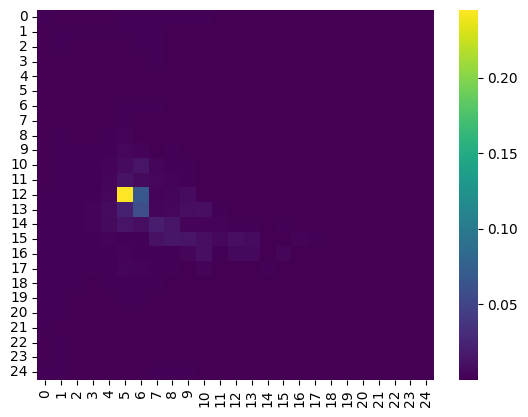

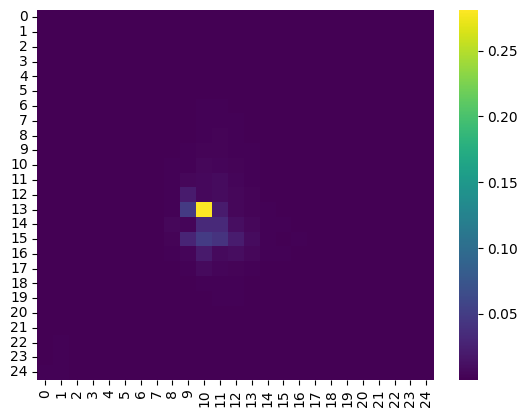

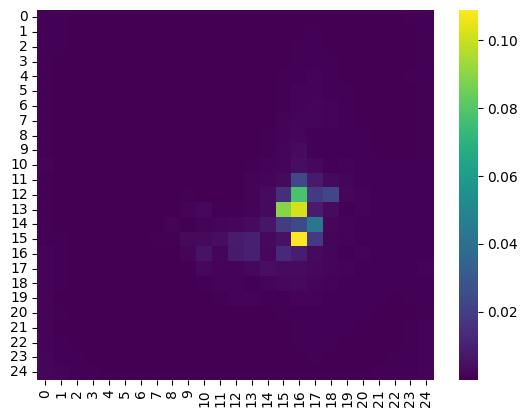

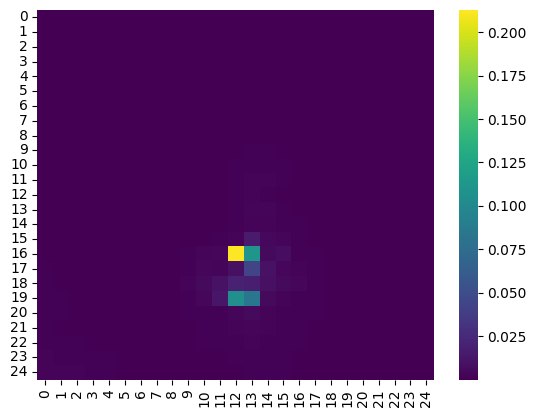

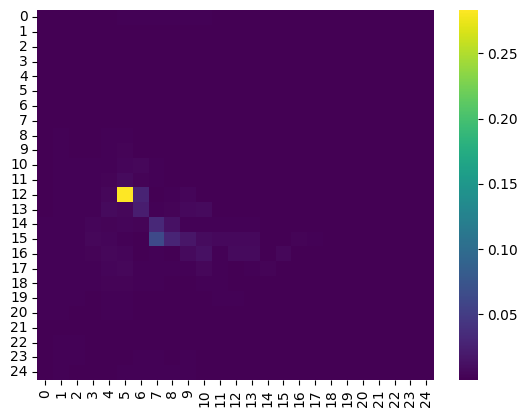

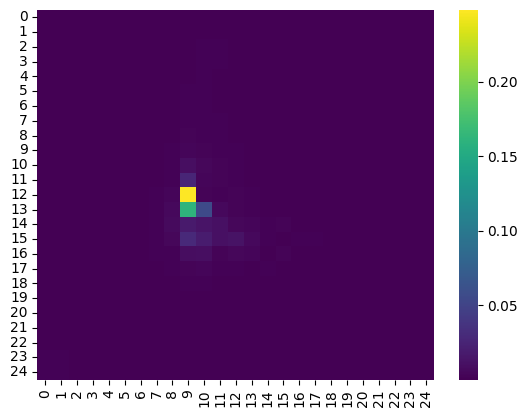

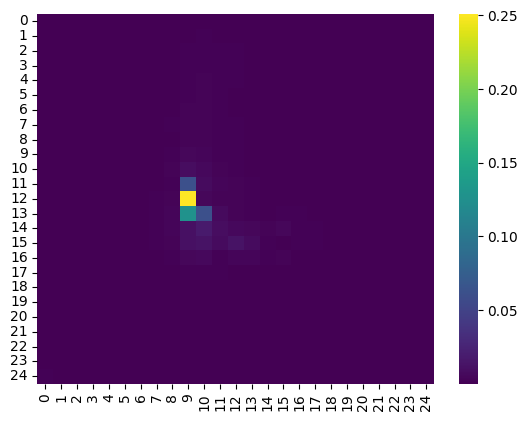

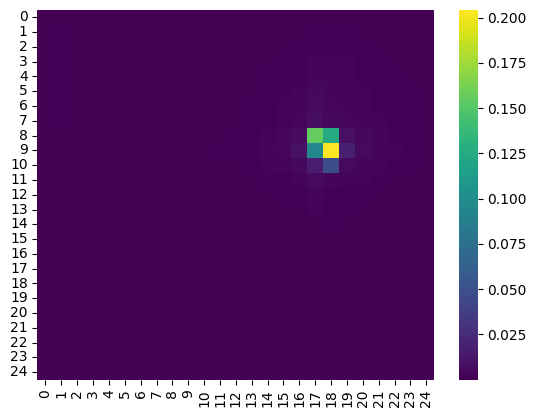

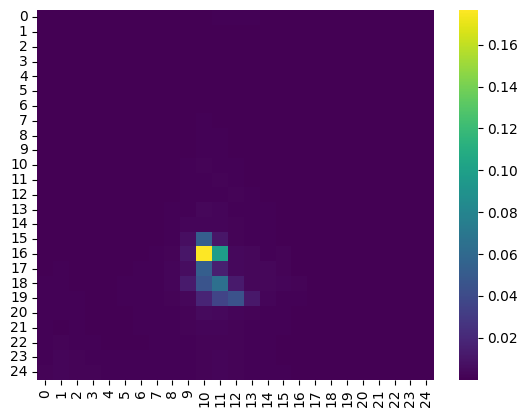

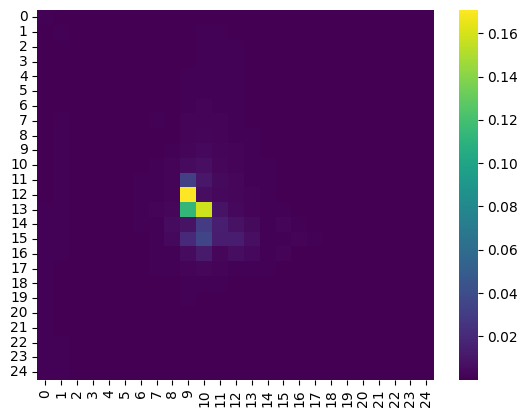

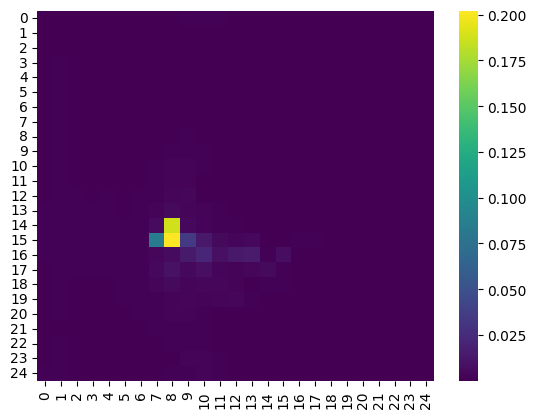

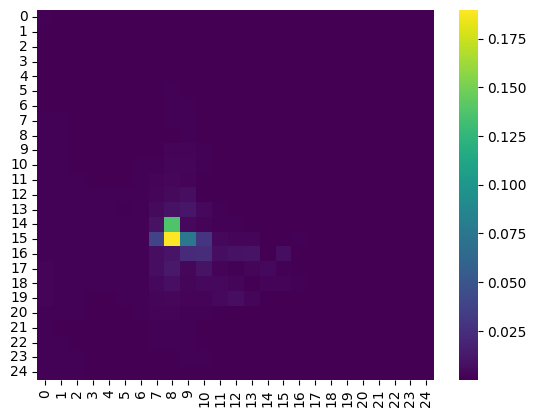

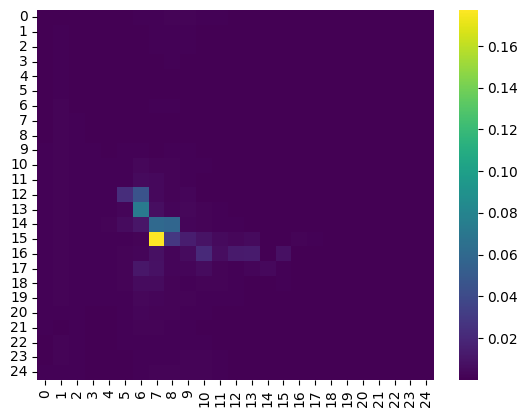

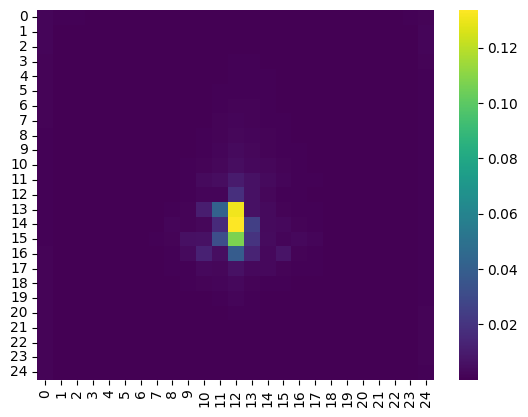

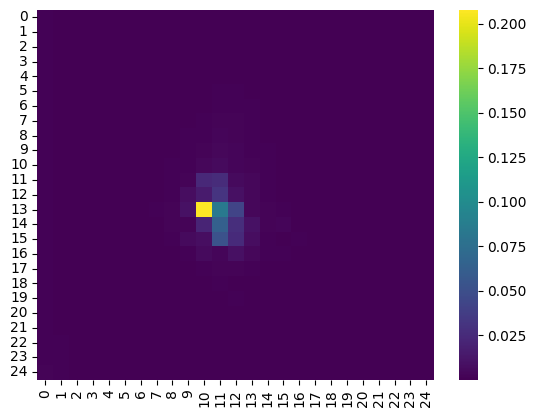

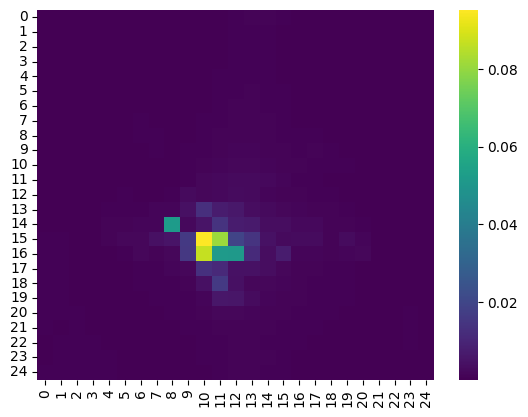

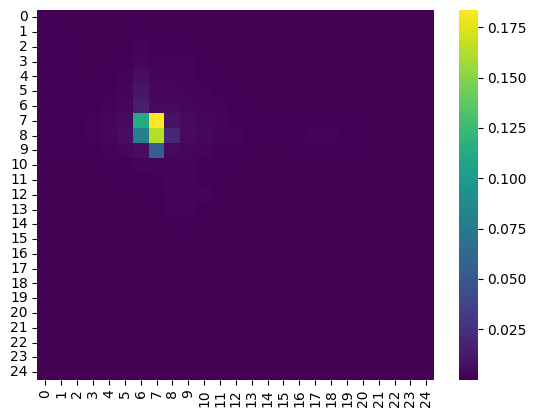

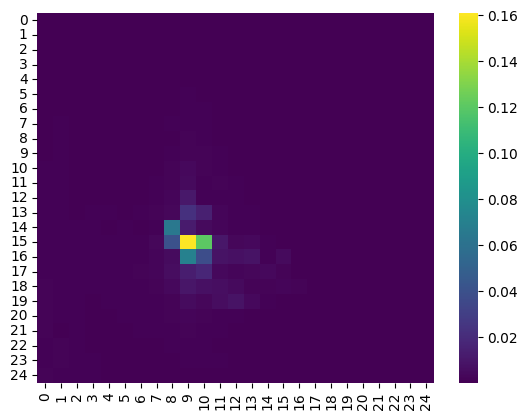

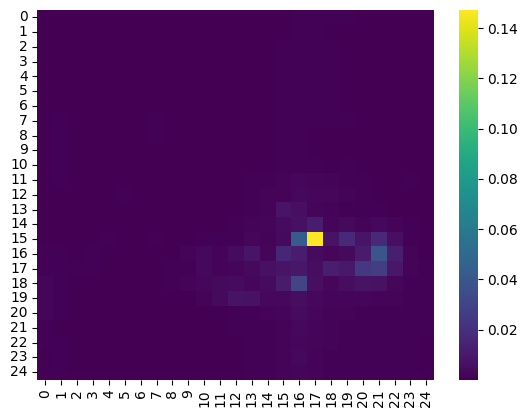

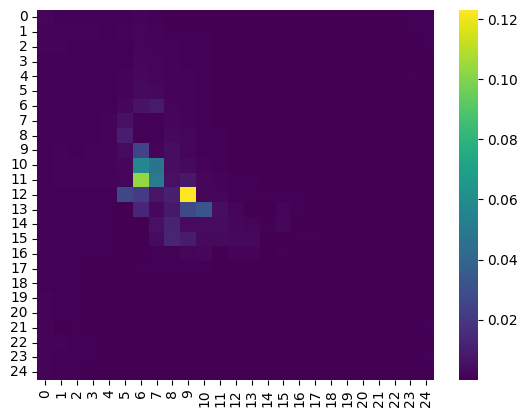

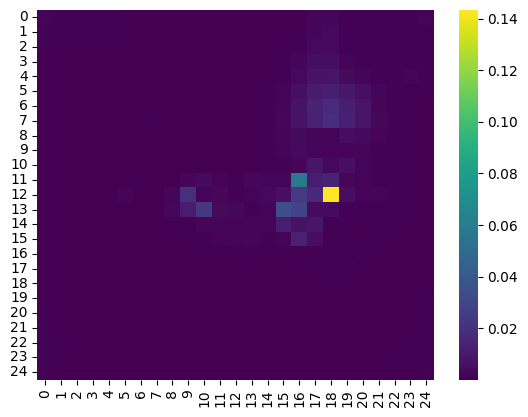

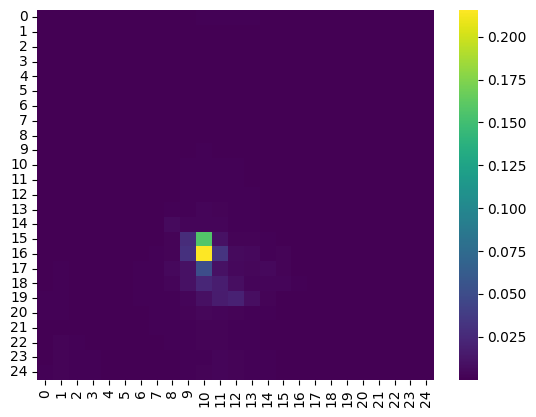

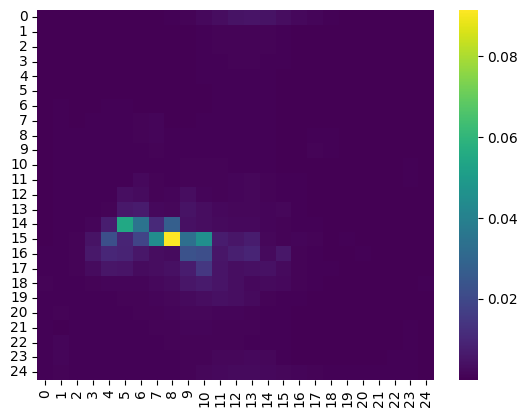

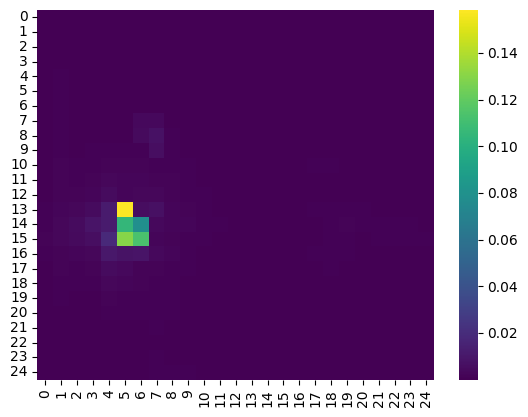

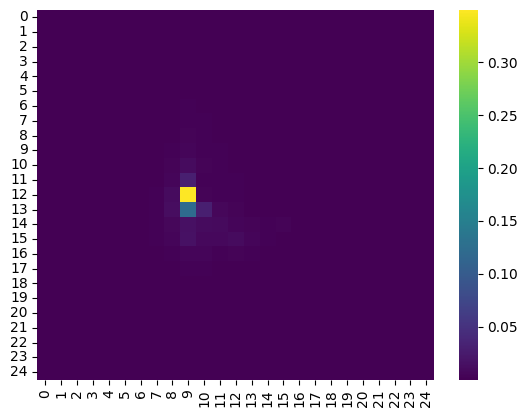

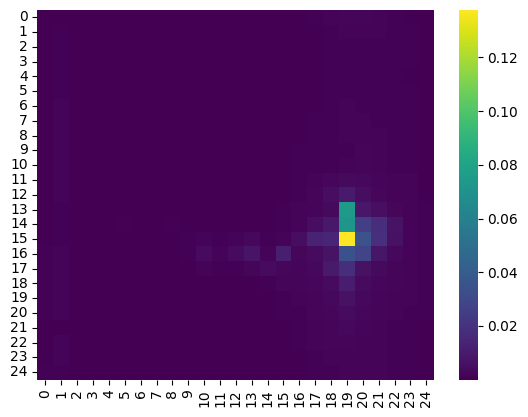

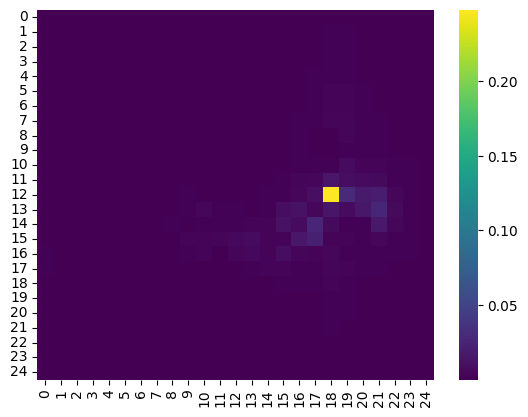

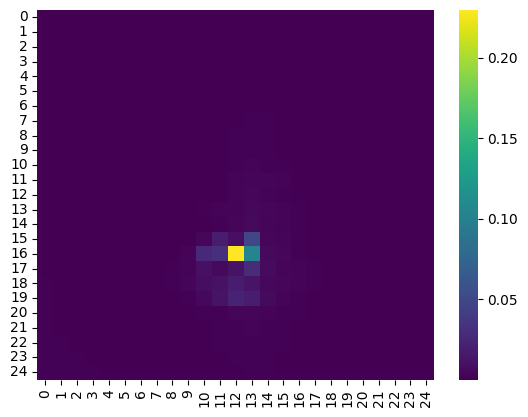

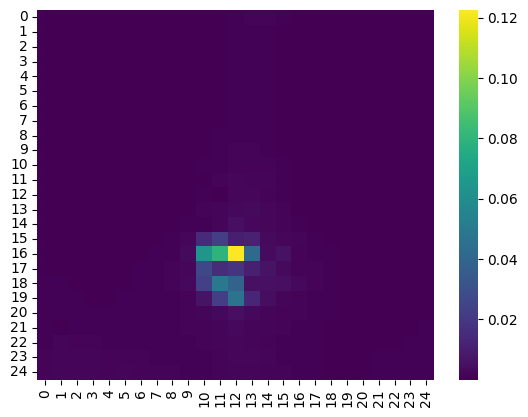

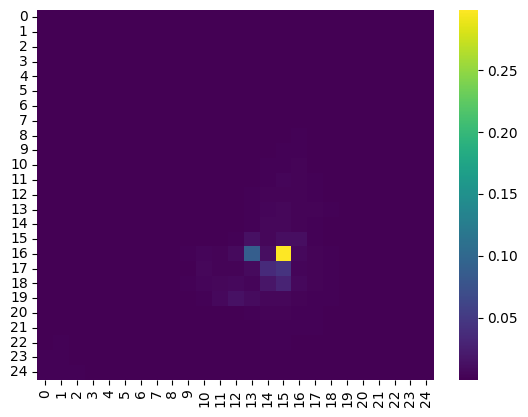

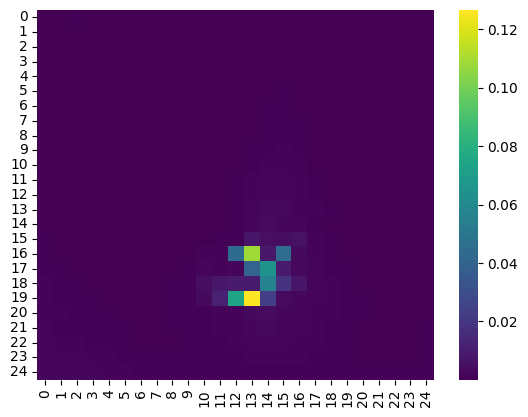

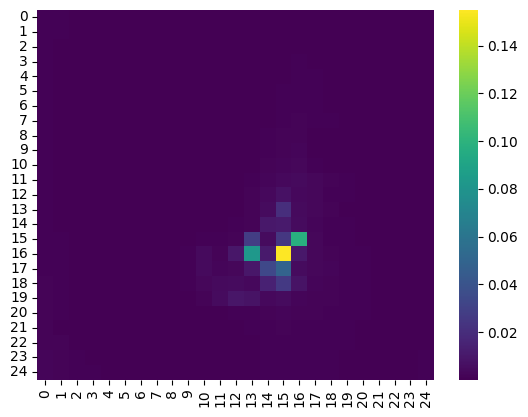

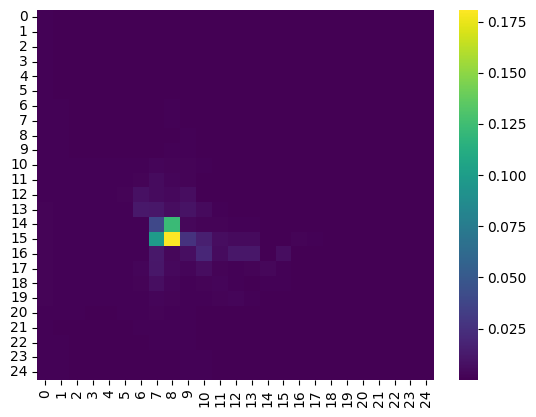

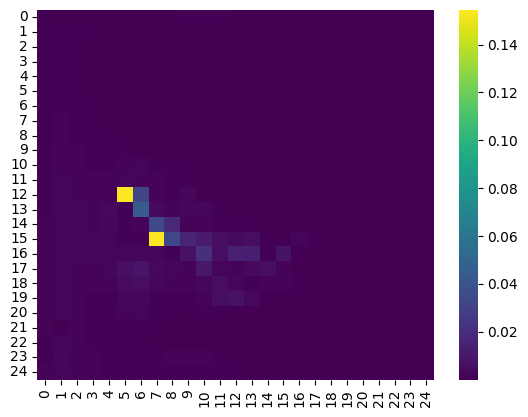

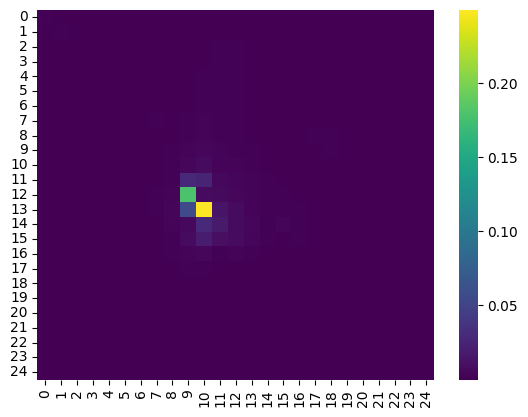

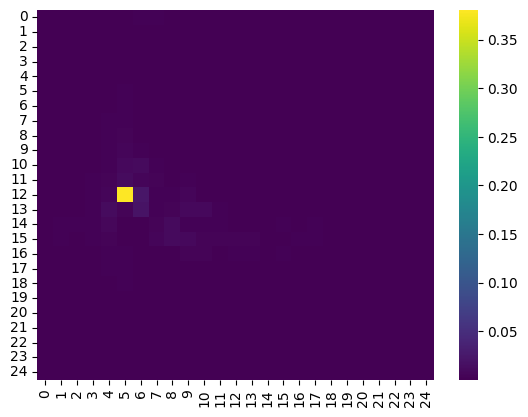

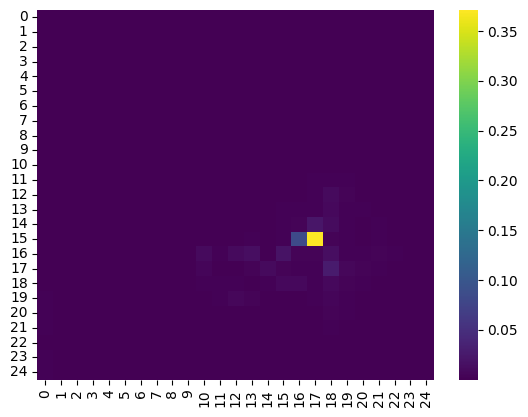

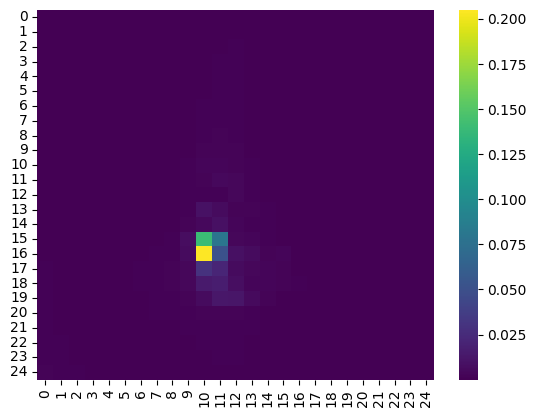

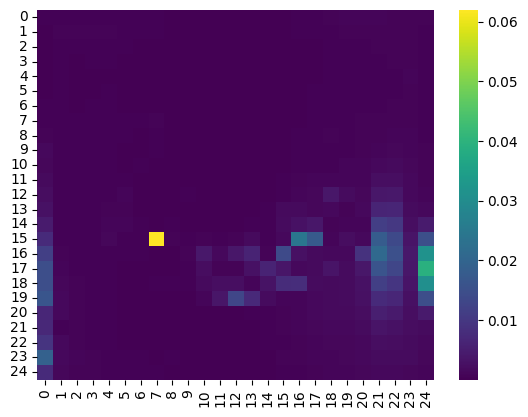

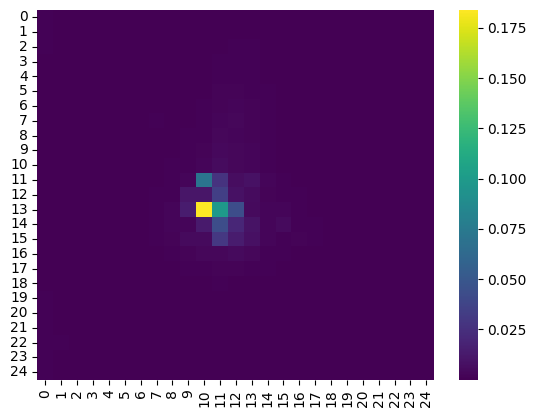

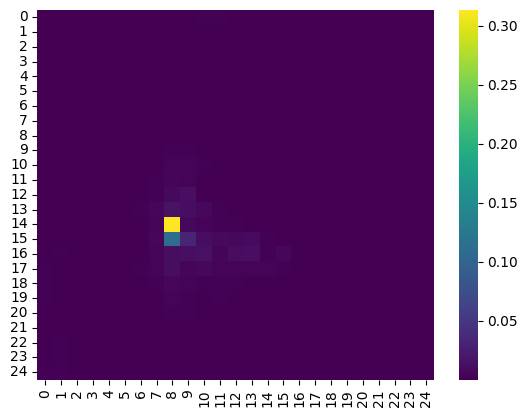

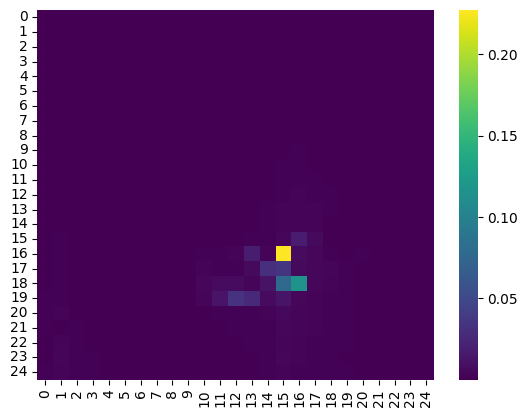

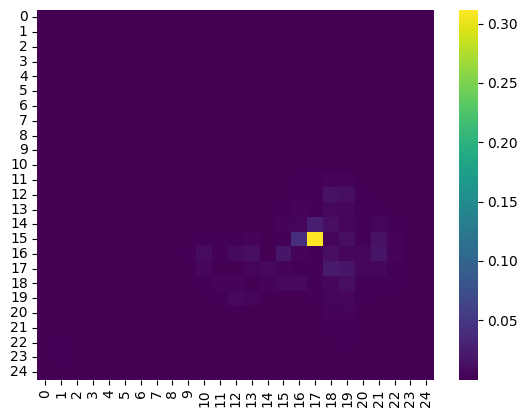

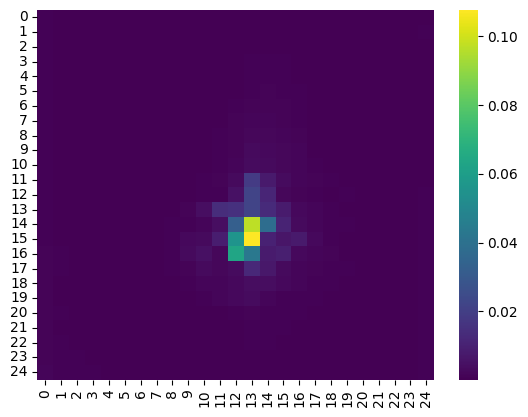

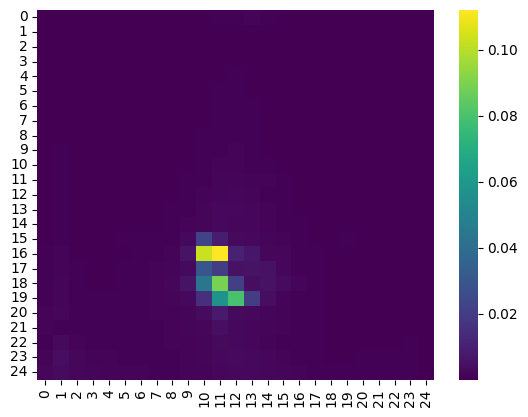

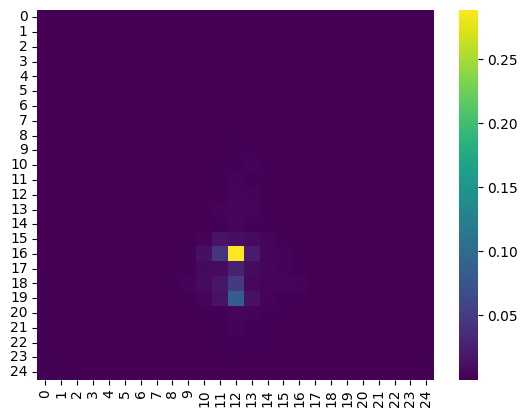

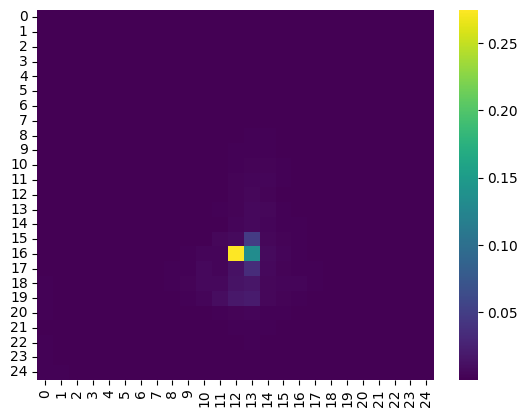

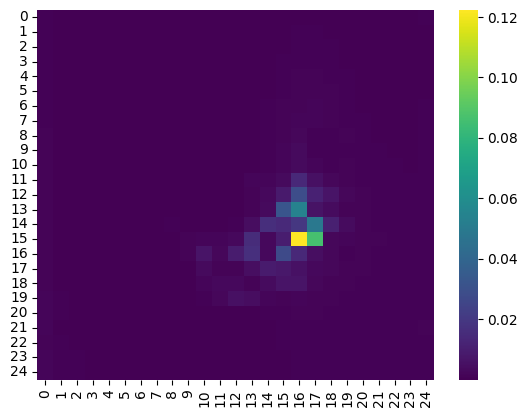

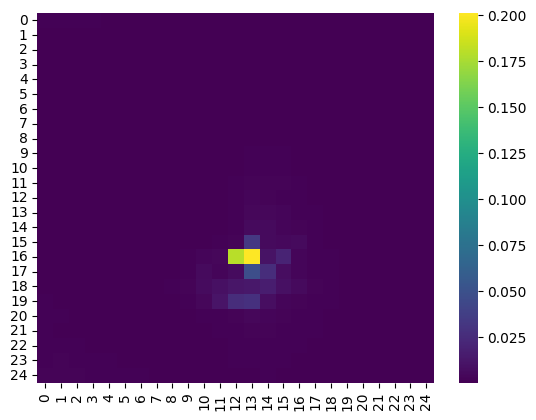

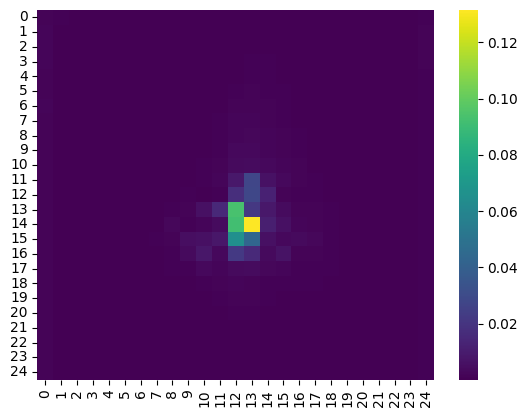

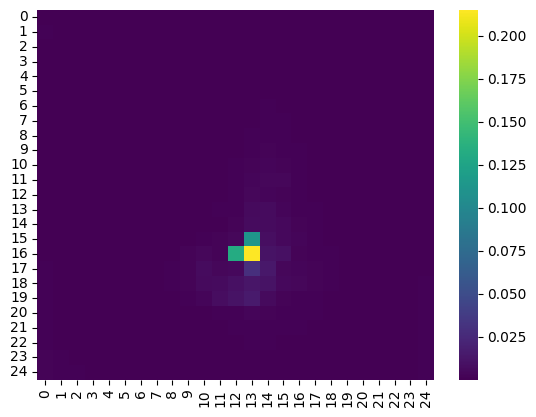

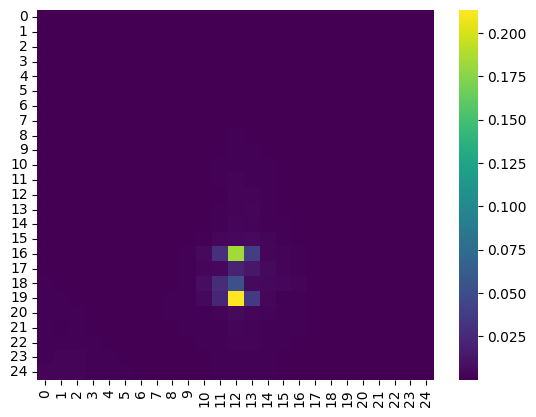

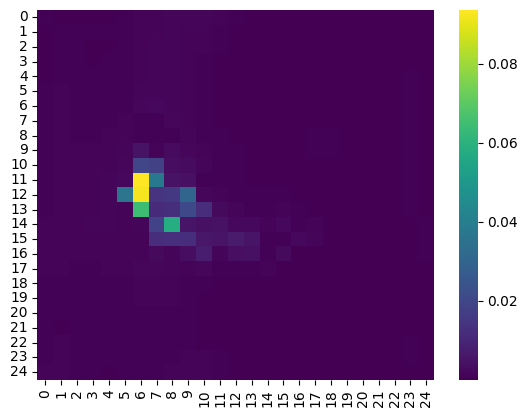

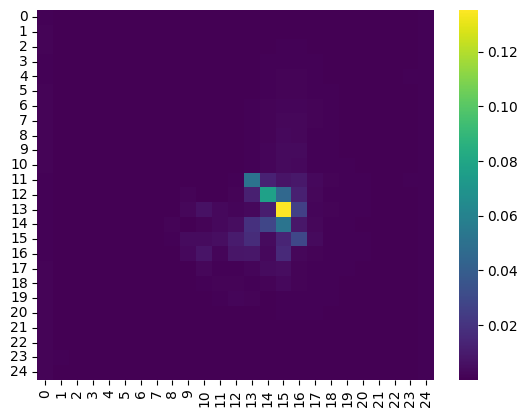

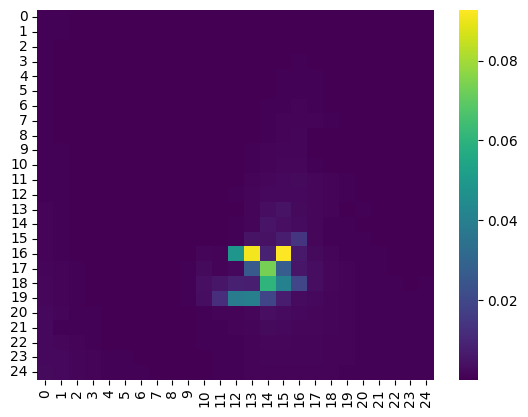

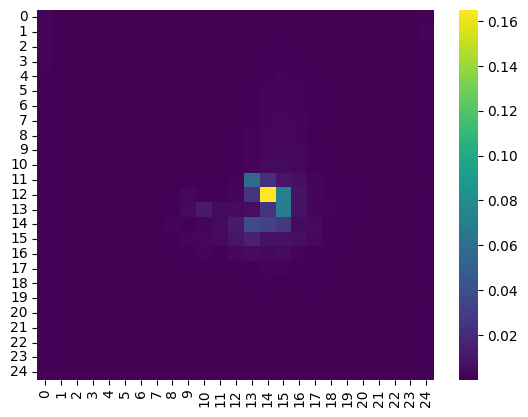

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs, output_attentions=True)

attention_map = outputs.cross_attentions[-1][0]
attention_mean=torch.mean(attention_map, dim=0)
for attentions in attention_mean:
    h, w = inputs['pixel_values'].shape[-2:]
    attention_map_resized = attentions.reshape(h // 32, w // 32).detach().cpu().numpy()
    sns.heatmap(attention_map_resized, cmap="viridis")
    plt.show()

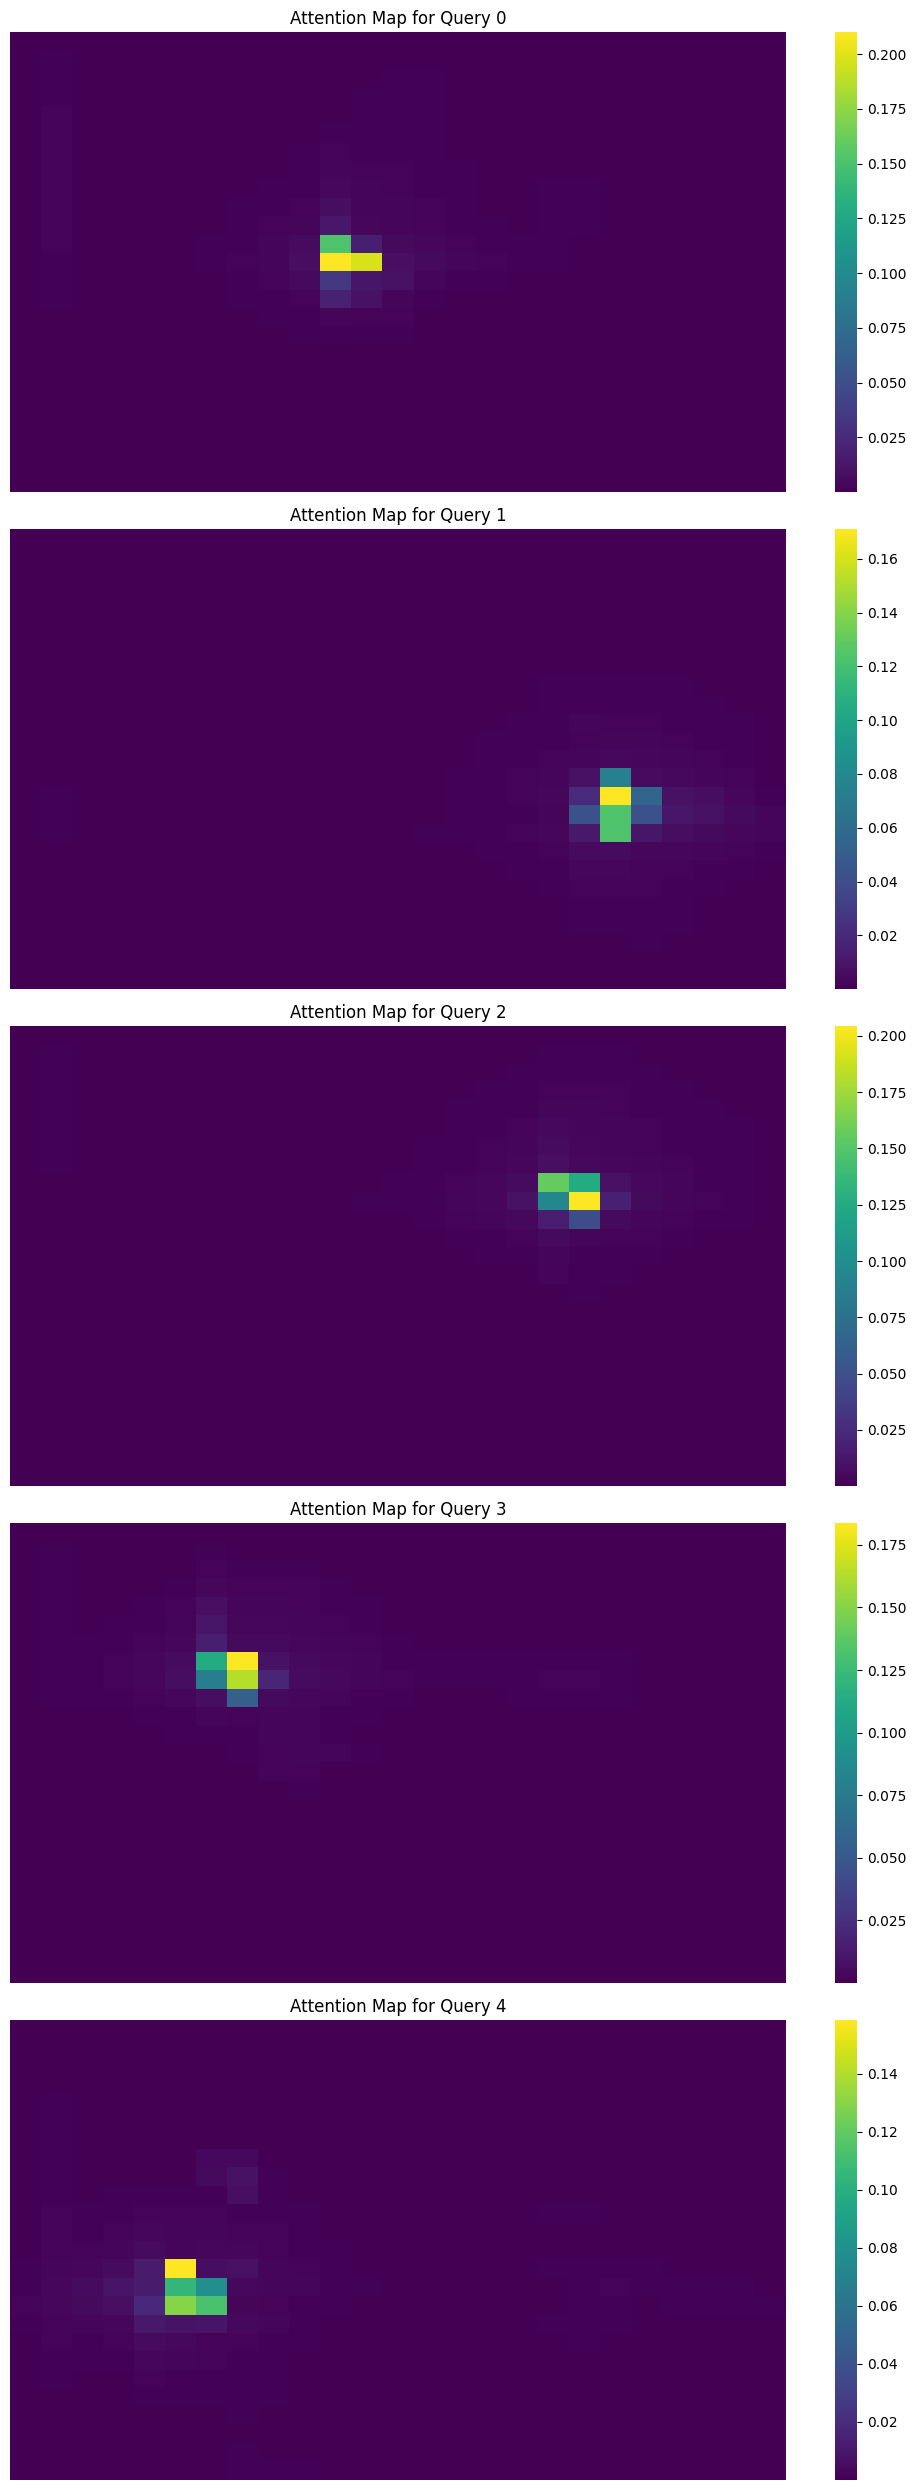

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.5

if len(keep.nonzero()) == 1:
    indices = keep.nonzero().squeeze(0)
else:
    indices = keep.nonzero().squeeze()

num_queries = len(indices)

if num_queries == 1:
    fig, axes = plt.subplots(figsize = (10, 5))
    axes = [axes]
else:
    fig, axes = plt.subplots(nrows=num_queries, ncols=1, figsize=(10, num_queries * 5))

all_head_attentions = outputs.cross_attentions[-1][0]  # (8, 100, 625)

# Head'lerin ortalamasını alın
mean_attention = torch.mean(all_head_attentions, dim=0)
for i in range(num_queries):
    # İlk head'i kullanarak attention haritasını alın
    attention_map = mean_attention[indices[i], :]  # (key_len)

    h, w = inputs['pixel_values'].shape[-2:]
    attention_map_resized = attention_map.reshape(25 , 25).detach().cpu().numpy() # Assuming feature map is 32x smaller

    # Görselleştirme
    sns.heatmap(attention_map_resized, cmap="viridis", ax=axes[i])
    axes[i].set_title(f"Attention Map for Query {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
annotation_file = "/content/data/test/_annotations.coco.json"

coco = COCO(annotation_file)

img_id = coco.getImgIds()[0]

img_info = coco.loadImgs(img_id)[0]

image_path = os.path.join("/content/data/test", img_info['file_name'])
image = Image.open(image_path).convert("RGB")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))

[{'id': 0,
  'image_id': 0,
  'category_id': 3,
  'bbox': [310, 342, 21, 113],
  'area': 2373,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 3,
  'bbox': [329, 346, 24.5, 106],
  'area': 2597,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 0,
  'category_id': 3,
  'bbox': [288, 341, 26.5, 116.5],
  'area': 3087.25,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 0,
  'category_id': 1,
  'bbox': [460, 332, 40.5, 152],
  'area': 6156,
  'segmentation': [],
  'iscrowd': 0}]

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


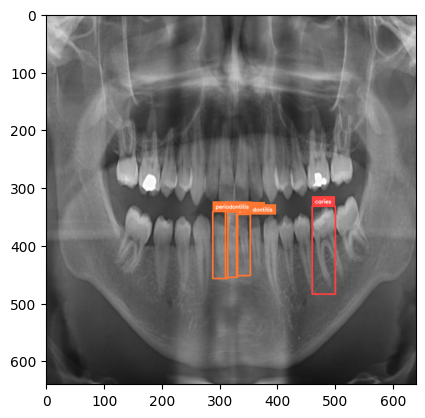

In [ ]:
annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))

xyxy = []
class_ids = []
for annotation in annotations:
    bbox = annotation['bbox']
    xyxy.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
    class_ids.append(annotation['category_id'])

detections = sv.Detections(
    xyxy=np.array(xyxy),
    class_id=np.array(class_ids),
)

box_annotator = sv.BoundingBoxAnnotator()

label_annotator = sv.LabelAnnotator(text_scale=0.3, text_padding=5, text_thickness=1) 

categories = coco.loadCats(coco.getCatIds())
category_names = {category['id']: category['name'] for category in categories}

labels = [category_names[class_id] for class_id in detections.class_id]


annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)

annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# Görüntüyü görüntüleyin
plt.imshow(annotated_frame)
plt.show()

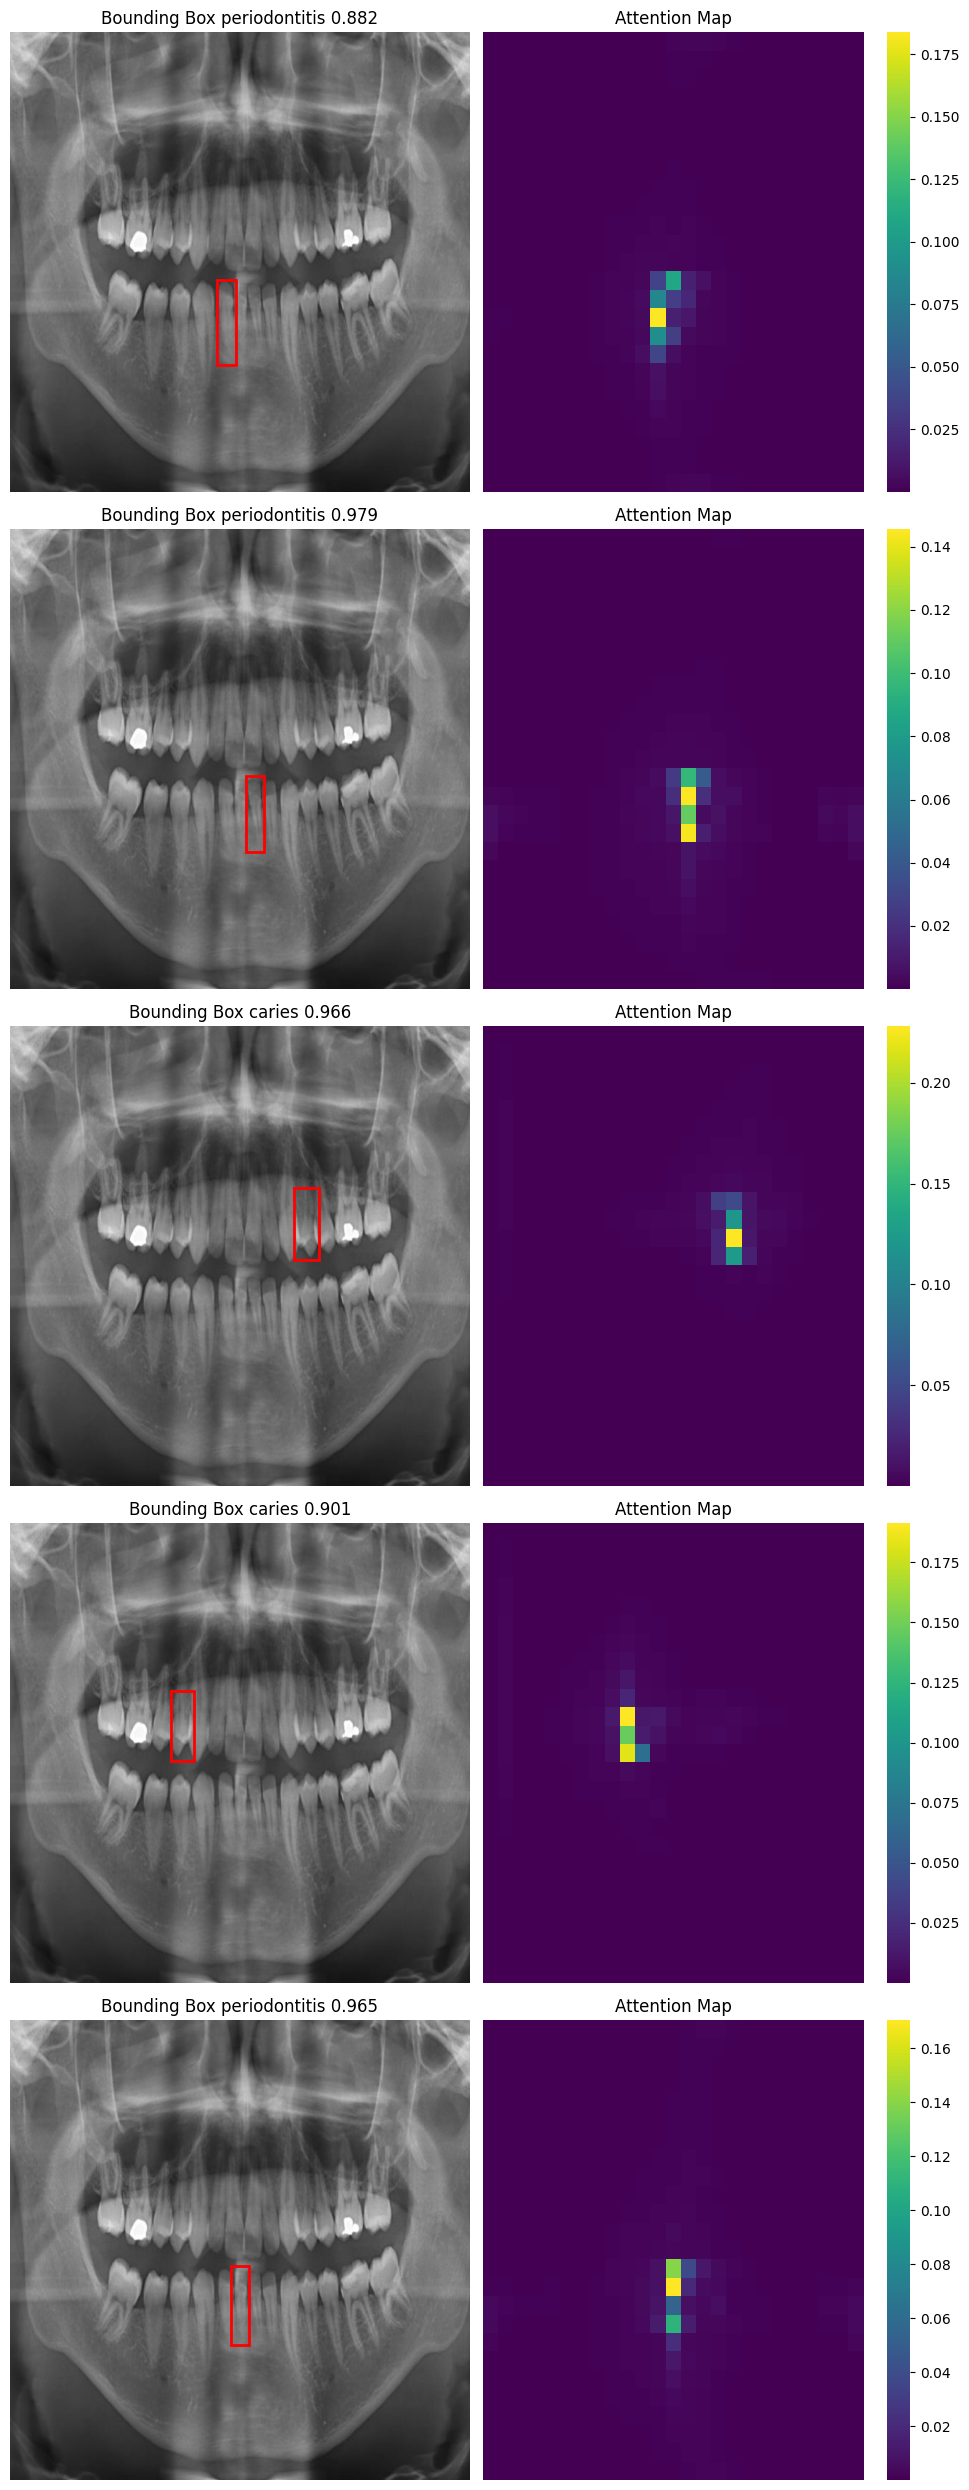

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

inputs = processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs, output_attentions=True)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.5

if len(keep.nonzero()) == 1:
    indices = keep.nonzero().squeeze(0)
else:
    indices = keep.nonzero().squeeze()

num_queries = len(indices)

if num_queries == 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
else:
    fig, axes = plt.subplots(nrows=num_queries, ncols=2, figsize=(10, num_queries * 5))

for i in range(num_queries):
    score = results["scores"][i].item()
    label = results["labels"][i].item()
    box = results["boxes"][i].tolist()
    xmin, ymin, xmax, ymax = box

    cropped_image = image.crop((xmin, ymin, xmax, ymax))

    attention_map = outputs.cross_attentions[-1][0]
    attention_map = torch.mean(attention_map, dim=0)
    attention_map = attention_map[indices[i], :].reshape(25, 25).detach().cpu().numpy()

    ax = axes[0] if num_queries == 1 else axes[i, 0]
    ax.imshow(image)
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.set_title(f"Bounding Box {model.config.id2label[label]} {score:.3f}")
    ax.axis("off")

    heatmap_ax = axes[1] if num_queries == 1 else axes[i,1]
    sns.heatmap(attention_map, cmap="viridis", ax=heatmap_ax)
    heatmap_ax.set_title(f"Attention Map")
    heatmap_ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
trainer.save_model("detr_xray")

In [ ]:
!zip -r detr_xray.zip /content/detr_xray

  adding: content/detr_xray/ (stored 0%)
  adding: content/detr_xray/model.safetensors (deflated 7%)
  adding: content/detr_xray/preprocessor_config.json (deflated 48%)
  adding: content/detr_xray/config.json (deflated 62%)
  adding: content/detr_xray/training_args.bin (deflated 52%)


In [ ]:
from google.colab import files
files.download('/content/detr_xray.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>